# Lecture 5: Batch Normalization and Residual Streams

In this lecture, we will discuss two important techniques that have been shown to be very effective in training deep neural networks: Batch Normalization and Residual Streams. We will discuss both of these techniques in detail and show how they can be used to improve the performance of deep neural networks.

### Importing libraries

In [1]:
import os
import matplotlib.pyplot as plt
import itertools
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from src.utils import load_text, set_seed, configure_device

### Configuration

In [2]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    vocab_size: int = 0  # Set later

    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 256

    # Training
    val_size: float = 0.1
    batch_size: int = 32
    max_steps: int = 1000
    lr: float = 0.01
    val_interval: int = 100

    seed: int = 101

config = MLPConfig()

## Reproducibility

In [3]:
set_seed(config.seed)

Random seed set to 101


## Device

In [4]:
config.device = configure_device()

Running on mps


## Dataset

In [5]:
# Load text and split by lines
names = load_text(config.root_dir + config.dataset_path).splitlines()

Loaded text data from /Users/pathfinder/Documents/GitHub/LLM101/notebooks/Lectures/../../data/names.txt (length: 228145 characters).


## Tokenizer

In [6]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
config.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

## Preprocessing

In [7]:
# Train-Val Split
train_names, val_names = train_test_split(names, test_size=config.val_size, random_state=config.seed)

In [8]:
class NamesDataset(Dataset):
    def __init__(self, _names, context_size):
        self.inputs, self.targets = [], []

        for name in _names:
            context = [0] * context_size

            for char in name + ".":
                idx = str2idx[char]
                self.inputs.append(context)
                self.targets.append(idx)
                context = context[1:] + [idx]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.inputs[idx])
        target_id = torch.tensor(self.targets[idx])
        return input_ids, target_id

train_dataset = NamesDataset(train_names, config.context_size)
val_dataset = NamesDataset(val_names, config.context_size)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

## Model

In [9]:
class MLP(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))

    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)

        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [10]:
# Initialize the model
mlp = MLP(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp.to(config.device) # Move the model to the device
print(mlp)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

MLP()
Number of parameters: 19915


In [11]:
# Training
def train(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        max_steps: int,
        lr: float,
        val_interval: int,
        device: torch.device
):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    steps = []
    train_losses = []
    val_losses = []
    train_iter = itertools.cycle(train_loader)  # Infinite dataloader

    for step in range(1, max_steps + 1):
        model.train()
        train_inputs, train_targets = next(train_iter)
        train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
        optimizer.zero_grad()
        logits = model(train_inputs)
        loss = F.cross_entropy(logits, train_targets)
        loss.backward()
        optimizer.step()
        steps.append(step)
        train_losses.append(loss.item())

        if step % val_interval == 0:
            model.eval()
            val_loss = 0.0
            total_samples = 0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_logits = model(val_inputs)
                    batch_loss = F.cross_entropy(val_logits, val_targets)
                    val_loss += batch_loss.item() * val_inputs.size(0)
                    total_samples += val_inputs.size(0)
            val_loss /= total_samples
            val_losses.append(val_loss)
            print(f"Step {step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

        if step == 1:
            print(f"Initial Train Loss = {loss.item():.4f}")

    # Plot the loss
    plt.figure()
    plt.plot(steps, train_losses, label="Train")
    val_steps = [step for step in steps if step % val_interval == 0]
    plt.plot(val_steps, val_losses, label="Validation")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Initial Train Loss = 32.5348
Step 100: Train Loss = 24.1774, Val Loss = 20.3608
Step 200: Train Loss = 19.1702, Val Loss = 16.8662
Step 300: Train Loss = 10.7864, Val Loss = 14.7275
Step 400: Train Loss = 14.2160, Val Loss = 13.2797
Step 500: Train Loss = 12.1662, Val Loss = 12.2998
Step 600: Train Loss = 15.8062, Val Loss = 11.5175
Step 700: Train Loss = 14.4778, Val Loss = 10.9088
Step 800: Train Loss = 13.4683, Val Loss = 10.3655
Step 900: Train Loss = 10.6566, Val Loss = 9.9281
Step 1000: Train Loss = 9.0144, Val Loss = 9.5601


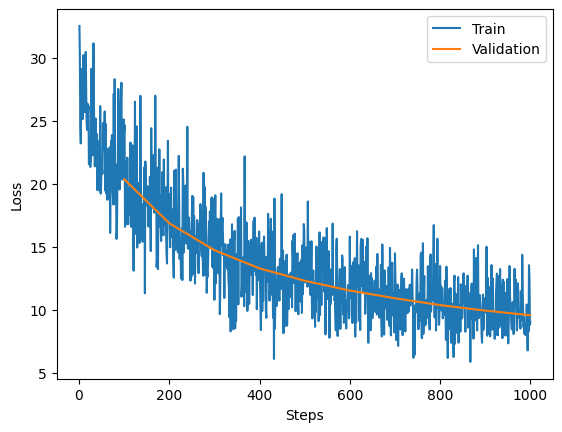

In [12]:
train(
    model=mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

### Part 1: Batch Normalization

Recall what we do for initializing the weights of a neural network.

1. We don't want the logits to be too big because the softmax might explode.
- Initialize the final layer with small values.
2. We don't want the gradients to vanish.
- Initialize the inner layer with small values.
- Use different activation functions.

Eventually, what we want is to preserve the same gaussian distribution of the activations.

**Why not just normalize the activations?** -> Key idea to [Batch Normalization](https://arxiv.org/pdf/1502.03167)

In [13]:
# MLP Model with Batch Normalization
class MLPv2(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))

        # Batch Normalization
        self.gamma = nn.Parameter(torch.ones(1, d_hidden))
        self.beta = nn.Parameter(torch.zeros(1, d_hidden))

    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        # Hidden layer
        x = x @ self.W1 + self.b1  # (batch_size, d_hidden)

        # Batch Normalization
        ################################################################################
        # TODO:                                                                        #
        # Implement the batch normalization for the hidden layer.                      #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True) + 1e-8  # add small value to avoid division by zero
        x = self.gamma * (x - mean) / std + self.beta  # (batch_size, d_hidden)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        h = F.tanh(x)  # (batch_size, d_hidden)

        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [14]:
# Initialize the model
mlpV2 = MLPv2(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlpV2.to(config.device) # Move the model to the device
print(mlpV2)
print("Number of parameters:", sum(p.numel() for p in mlpV2.parameters()))

MLPv2()
Number of parameters: 20427


Initial Train Loss = 20.5092
Step 100: Train Loss = 15.4263, Val Loss = 13.8811
Step 200: Train Loss = 14.5552, Val Loss = 11.2574
Step 300: Train Loss = 8.9287, Val Loss = 9.7377
Step 400: Train Loss = 9.8745, Val Loss = 8.5171
Step 500: Train Loss = 7.2062, Val Loss = 7.5893
Step 600: Train Loss = 8.2828, Val Loss = 6.8738
Step 700: Train Loss = 6.8111, Val Loss = 6.3159
Step 800: Train Loss = 5.1058, Val Loss = 5.9097
Step 900: Train Loss = 5.0835, Val Loss = 5.5433
Step 1000: Train Loss = 6.3539, Val Loss = 5.2432


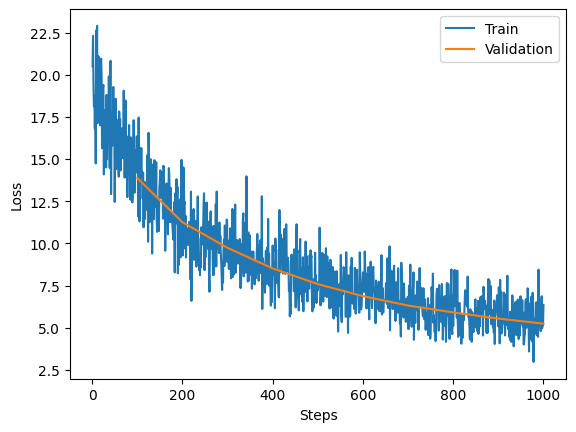

In [15]:
train(
    model=mlpV2,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

In [16]:
# MLP Model with more layers
class MLPv3(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden, kaiming_init=False, batch_norm=False):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, d_hidden * 2))
        self.W3 = nn.Parameter(torch.randn(d_hidden * 2, d_hidden))
        self.W4 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        ################################################################################
        # TODO:                                                                        #
        # Where did the biases go?                                                     #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kaiming_init = kaiming_init

        # Batch Normalization
        self.batch_norm = batch_norm
        self.gamma1 = nn.Parameter(torch.ones(1, d_hidden))
        self.beta1 = nn.Parameter(torch.zeros(1, d_hidden))
        self.gamma2 = nn.Parameter(torch.ones(1, d_hidden * 2))
        self.beta2 = nn.Parameter(torch.zeros(1, d_hidden * 2))
        self.gamma3 = nn.Parameter(torch.ones(1, d_hidden))
        self.beta3 = nn.Parameter(torch.zeros(1, d_hidden))

    def forward(self, x):  # x: (batch_size, context_size)
        # Kaiming Initialization
        if self.kaiming_init:
            nn.init.kaiming_normal_(self.W1, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W2, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W3, mode='fan_in', nonlinearity='tanh')
            nn.init.kaiming_normal_(self.W4, mode='fan_in', nonlinearity='tanh')

        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)

        # Hidden layer 1
        x = x @ self.W1  # (batch_size, d_hidden)
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma1 * (x - mean) / std + self.beta1
        h1 = F.tanh(x)

        # Hidden layer 2
        x = h1 @ self.W2
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma2 * (x - mean) / std + self.beta2
        h2 = F.tanh(x)

        # Hidden layer 3
        x = h2 @ self.W3
        if self.batch_norm:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True) + 1e-8
            x = self.gamma3 * (x - mean) / std + self.beta3
        h3 = F.tanh(x)

        # Output layer
        logits = h3 @ self.W4  # (batch_size, vocab_size)
        return logits

In [17]:
# mlpV3 = Kaiming_init=False, BatchNorm=False
# mlpV4 = Kaiming_init=True, BatchNorm=False
# mlpV5 = Kaiming_init=False, BatchNorm=True

mlpV3 = MLPv3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden,
              kaiming_init=False, batch_norm=False)
mlpV3.to(config.device)

mlpV4 = MLPv3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden,
              kaiming_init=True, batch_norm=False)
mlpV4.to(config.device)

mlpV5 = MLPv3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden,
              kaiming_init=False, batch_norm=True)
mlpV5.to(config.device)

MLPv3()

Initial Train Loss = 34.3810
Step 100: Train Loss = 26.9561, Val Loss = 26.2813
Step 200: Train Loss = 23.7408, Val Loss = 23.2247
Step 300: Train Loss = 20.4239, Val Loss = 21.4258
Step 400: Train Loss = 21.1898, Val Loss = 19.0520
Step 500: Train Loss = 16.7041, Val Loss = 18.6555
Step 600: Train Loss = 15.2069, Val Loss = 18.3569
Step 700: Train Loss = 20.9147, Val Loss = 17.7739
Step 800: Train Loss = 19.2005, Val Loss = 16.6122
Step 900: Train Loss = 15.2990, Val Loss = 16.8059
Step 1000: Train Loss = 23.5232, Val Loss = 16.4102


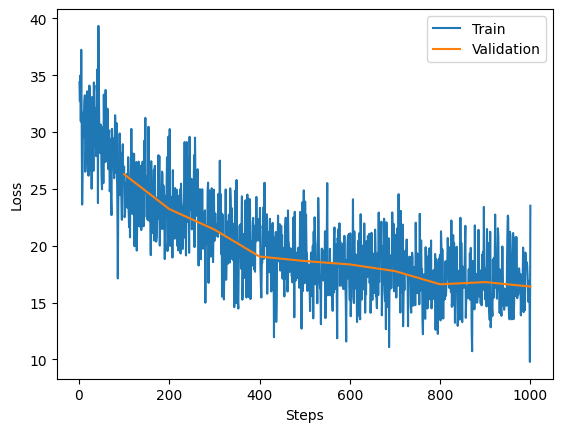

In [18]:
train(
    model=mlpV3,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

Initial Train Loss = 8.7460
Step 100: Train Loss = 7.4689, Val Loss = 7.3857
Step 200: Train Loss = 7.2763, Val Loss = 7.4134
Step 300: Train Loss = 7.1736, Val Loss = 7.3996
Step 400: Train Loss = 6.6064, Val Loss = 7.3893
Step 500: Train Loss = 7.4162, Val Loss = 7.4102
Step 600: Train Loss = 7.7049, Val Loss = 7.4051
Step 700: Train Loss = 8.6538, Val Loss = 7.3411
Step 800: Train Loss = 7.6889, Val Loss = 7.3149
Step 900: Train Loss = 7.5114, Val Loss = 7.3574
Step 1000: Train Loss = 7.9260, Val Loss = 7.3560


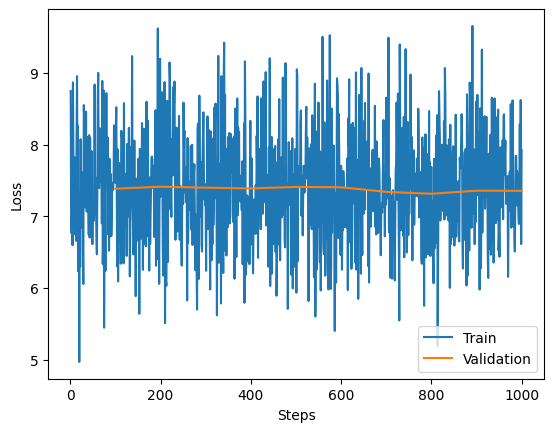

In [19]:
train(
    model=mlpV4,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

Initial Train Loss = 17.8264
Step 100: Train Loss = 9.9074, Val Loss = 11.8338
Step 200: Train Loss = 12.1658, Val Loss = 9.6013
Step 300: Train Loss = 8.7256, Val Loss = 8.2829
Step 400: Train Loss = 9.2165, Val Loss = 7.3851
Step 500: Train Loss = 7.7001, Val Loss = 6.7541
Step 600: Train Loss = 6.3313, Val Loss = 6.2400
Step 700: Train Loss = 6.5958, Val Loss = 5.8658
Step 800: Train Loss = 6.8349, Val Loss = 5.5493
Step 900: Train Loss = 5.0261, Val Loss = 5.2669
Step 1000: Train Loss = 4.8921, Val Loss = 5.0349


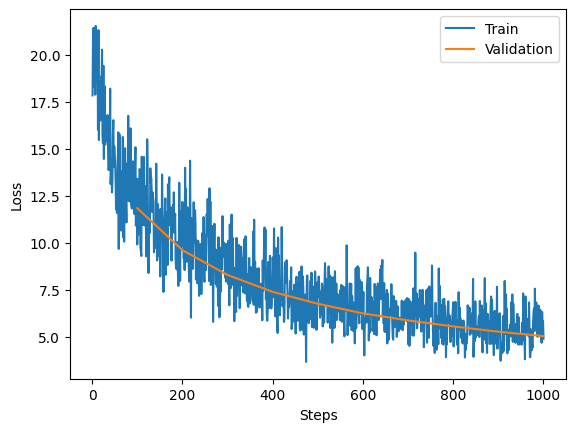

In [20]:
train(
    model=mlpV5,
    train_loader=train_loader,
    val_loader=val_loader,
    max_steps=config.max_steps,
    lr=config.lr,
    val_interval=config.val_interval,
    device=config.device
)

### Part 2: Residual Streams

## Conclusion

Deep, deep neural networks is all about optimization.
- [VGGNet, 2014](https://arxiv.org/pdf/1409.1556): 19 layers ("very deep" for 19 layers...)
- [ResNet, 2015](https://arxiv.org/pdf/1512.03385): 152 layers
- [GPT-3, 2020](https://arxiv.org/pdf/2005.14165): 96 layers

Why didn't researchers add layers for better performance before?

**Because it wasn't optimizable.**

Batch Normalization and Residual Streams are two key techniques that made it possible to train deep neural networks such as **Transformers**.

